In [1]:
import pandas as pd

# Load the game.csv and officials.csv files
games_df = pd.read_csv('csv/game.csv')

# Create the 'season_year' column
games_df['season_year'] = games_df['season_id'].astype(str).str[1:].astype(int)

# Filter out regular games after the year 2000
regular_games_post_2010_df = games_df[(games_df['season_year'] >= 2010) & (games_df['season_type'] == 'Regular Season')]

In [9]:
# Extract useful columns
home_stats = regular_games_post_2010_df[['season_year', 'team_id_home', 'fga_home', 'fg3a_home', 'fg3m_home', 'pts_home', 'fta_home', 'reb_home', 'wl_home']].rename(columns={
    'team_id_home': 'team_id',
    'fga_home': 'fga',
    'fg3a_home': 'fg3a',
    'fg3m_home': 'fg3m',
    'pts_home': 'pts',
    'fta_home': 'fta',
    'reb_home': 'reb',
    'wl_home': 'win'
})
home_stats['win'] = home_stats['win'].apply(lambda x: 1 if x == 'W' else 0)
home_stats['loss'] = home_stats['win'].apply(lambda x: 0 if x == 1 else 1)
# Calculate TS% and RR for home stats
home_stats['ts%'] = home_stats['pts'] / (2 * (home_stats['fga'] + 0.44 * home_stats['fta']))
# Assuming total available rebounds is home + away rebounds for RR calculation
home_stats['rr'] = home_stats['reb'] / (home_stats['reb'] + regular_games_post_2010_df['reb_away']) 

away_stats = regular_games_post_2010_df[['season_year', 'team_id_away', 'fga_away', 'fg3a_away', 'fg3m_away', 'pts_away', 'fta_away', 'reb_away', 'wl_away']].rename(columns={
    'team_id_away': 'team_id',
    'fga_away': 'fga',
    'fg3a_away': 'fg3a',
    'fg3m_away': 'fg3m',
    'pts_away': 'pts',
    'fta_away': 'fta',
    'reb_away': 'reb',
    'wl_away': 'win'
})
away_stats['win'] = away_stats['win'].apply(lambda x: 1 if x == 'W' else 0)
away_stats['loss'] = away_stats['win'].apply(lambda x: 0 if x == 1 else 1)
# Calculate TS% and RR for away stats
away_stats['ts%'] = away_stats['pts'] / (2 * (away_stats['fga'] + 0.44 * away_stats['fta']))
# Assuming total available rebounds is home + away rebounds for RR calculation
away_stats['rr'] = away_stats['reb'] / (away_stats['reb'] + regular_games_post_2010_df['reb_home'])

# Combine home and away stats
combined_stats = pd.concat([home_stats, away_stats])

# Perform aggregation
team_season_aggregate = combined_stats.groupby(['season_year', 'team_id']).agg({
    'fga': 'sum',
    'fg3a': 'sum',
    'fg3m': 'sum',
    'win': 'sum',
    'loss': 'sum',
    'ts%': 'mean',  
    'rr': 'mean'    
}).reset_index()

# Calculate derived metrics
team_season_aggregate['3pt/fg'] = round(100 * team_season_aggregate['fg3a'] / team_season_aggregate['fga'], 2)
team_season_aggregate['3pt_pct'] = round(100 * team_season_aggregate['fg3m'] / team_season_aggregate['fg3a'], 2)
team_season_aggregate['win%'] = round(100 * team_season_aggregate['win'] / (team_season_aggregate['win'] + team_season_aggregate['loss']), 2)

# Create and map team abbreviations
team_abbr_dict = regular_games_post_2010_df.groupby('team_id_home')['team_abbreviation_home'].agg(lambda x: list(x.unique())).to_dict()
team_season_aggregate['team_abbreviations'] = team_season_aggregate['team_id'].map(team_abbr_dict)


In [14]:
print(team_season_aggregate.head(10))

   season_year     team_id     fga    fg3a   fg3m  win  loss       ts%  \
0         2010  1610612737  6429.0  1427.0  502.0   44    38  0.542828   
1         2010  1610612738  6219.0  1119.0  408.0   56    26  0.562320   
2         2010  1610612739  6647.0  1489.0  509.0   19    63  0.518565   
3         2010  1610612740  6416.0  1232.0  444.0   46    36  0.537464   
4         2010  1610612741  6587.0  1415.0  511.0   62    20  0.542724   
5         2010  1610612742  6463.0  1768.0  645.0   57    25  0.565707   
6         2010  1610612743  6613.0  1704.0  662.0   50    32  0.573890   
7         2010  1610612744  7047.0  1749.0  685.0   36    46  0.544486   
8         2010  1610612745  6975.0  1843.0  677.0   43    39  0.551581   
9         2010  1610612746  6594.0  1519.0  513.0   32    50  0.535904   

         rr  3pt/fg  3pt_pct   win% team_abbreviations  
0  0.491610   22.20    35.18  53.66              [ATL]  
1  0.493967   17.99    36.46  68.29              [BOS]  
2  0.480119   

In [19]:
import statsmodels.api as sm

# Define the independent variables X and add a constant term (for the intercept)
X = team_season_aggregate[['3pt/fg', '3pt_pct', 'rr', 'ts%']]
X = sm.add_constant(X)

# Define the dependent variable y
y = team_season_aggregate['win%']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the summary
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   win%   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     119.4
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           1.96e-64
Time:                        05:44:26   Log-Likelihood:                -1326.8
No. Observations:                 360   AIC:                             2664.
Df Residuals:                     355   BIC:                             2683.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -371.2179     20.224    -18.356      0.000    -410.991    -331.445
3pt/fg        -0.4842      0.098     -4.960      0.000      -0.676      -0.292
3pt_pct        2.2826      0.384      5.939      0.000       1.527       3.038
rr           362.4597     35.246     10.284      0.000     293.142     431.777
ts%          314.1252     39.704      7.912      0.000     236.041     392.209
==============================================================================
Omnibus:                        0.312   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.855   Jarque-Bera (JB):                0.405
Skew:                          -0.063   Prob(JB):                        0.817
Kurtosis:                       2.894   Cond. No.                     3.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

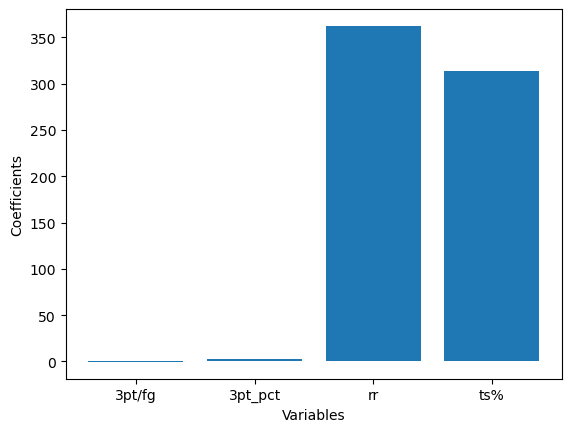

In [20]:
import matplotlib.pyplot as plt

# Regression Coefficients
coefs = model.params[1:]  # exclude the intercept
plt.bar(coefs.index, coefs.values)
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.show()


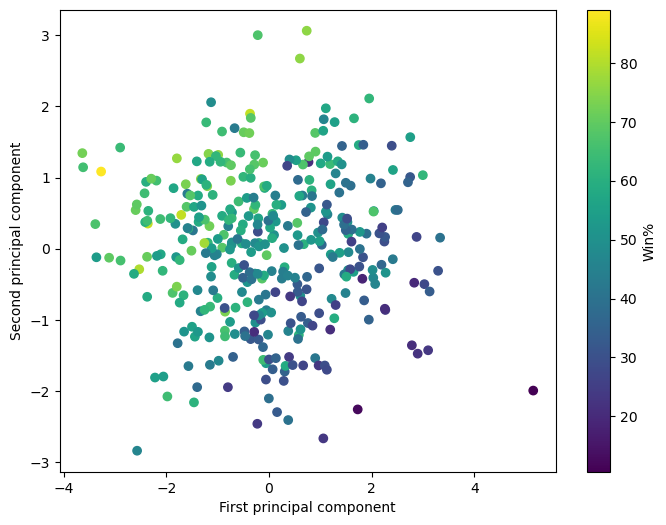

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
X_standardized = StandardScaler().fit_transform(team_season_aggregate[['3pt/fg', '3pt_pct', 'rr', 'ts%']])

# Perform PCA
pca = PCA(n_components=2)  # for example, reduce to 2 dimensions
X_pca = pca.fit_transform(X_standardized)

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=team_season_aggregate['win%'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(label='Win%')
plt.show()


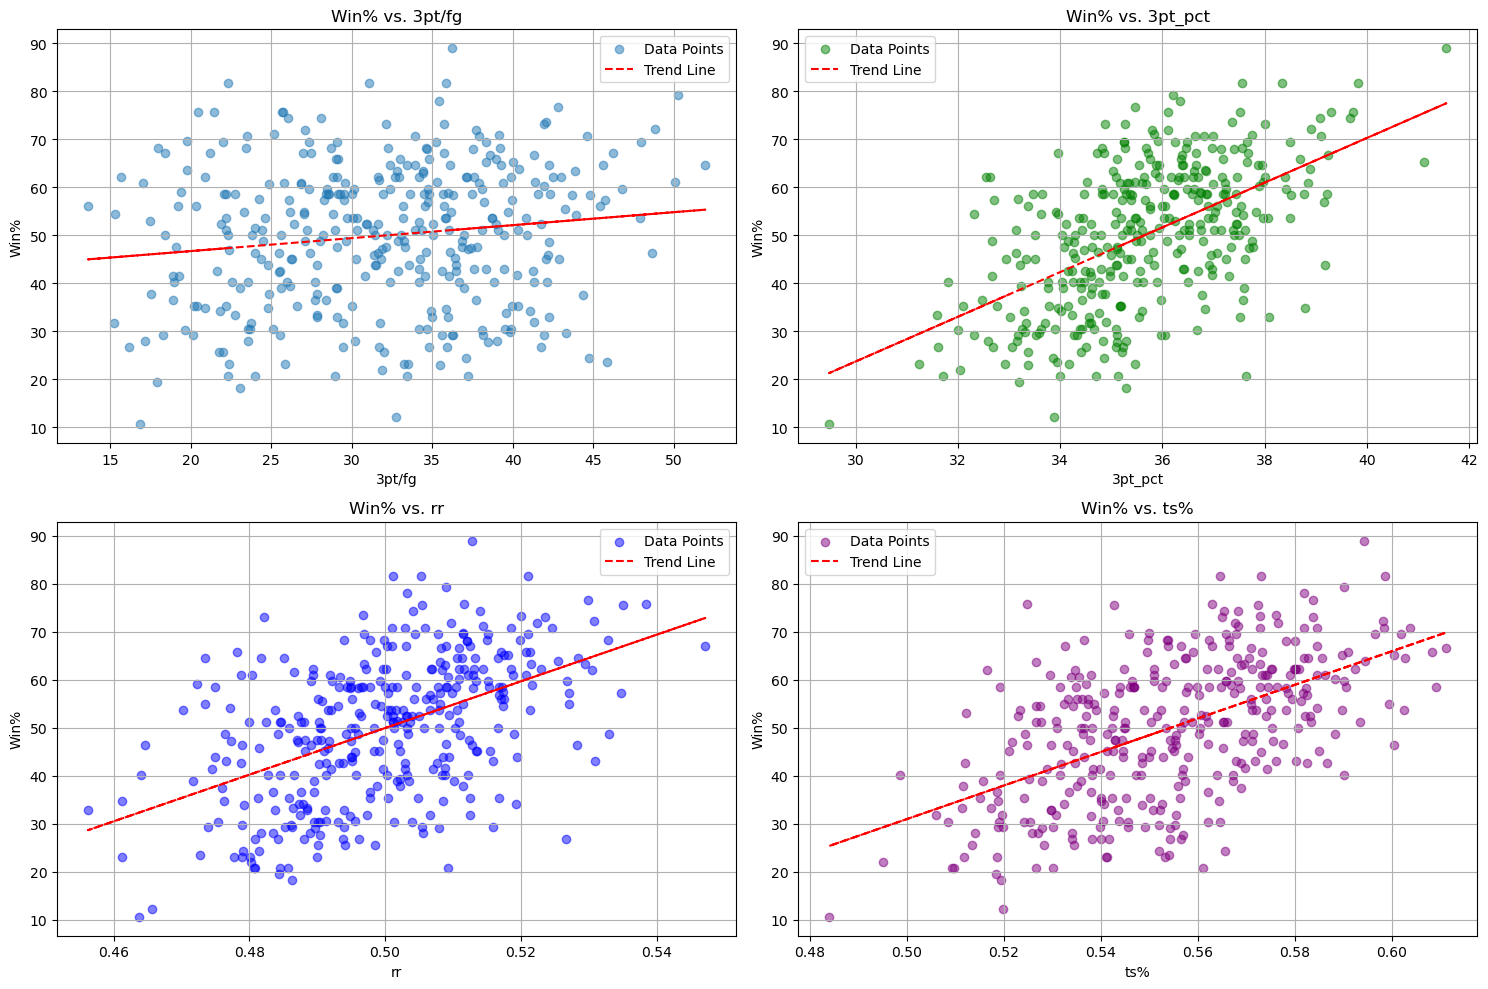

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting setup
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Win% vs. 3pt/fg
axs[0, 0].scatter(team_season_aggregate['3pt/fg'], team_season_aggregate['win%'], alpha=0.5, label='Data Points')
z = np.polyfit(team_season_aggregate['3pt/fg'], team_season_aggregate['win%'], 1)
p = np.poly1d(z)
axs[0, 0].plot(team_season_aggregate['3pt/fg'], p(team_season_aggregate['3pt/fg']), "r--", label='Trend Line')
axs[0, 0].set_title('Win% vs. 3pt/fg')
axs[0, 0].set_xlabel('3pt/fg')
axs[0, 0].set_ylabel('Win%')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Win% vs. 3pt_pct
axs[0, 1].scatter(team_season_aggregate['3pt_pct'], team_season_aggregate['win%'], alpha=0.5, label='Data Points', c='green')
z = np.polyfit(team_season_aggregate['3pt_pct'], team_season_aggregate['win%'], 1)
p = np.poly1d(z)
axs[0, 1].plot(team_season_aggregate['3pt_pct'], p(team_season_aggregate['3pt_pct']), "r--", label='Trend Line')
axs[0, 1].set_title('Win% vs. 3pt_pct')
axs[0, 1].set_xlabel('3pt_pct')
axs[0, 1].set_ylabel('Win%')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Win% vs. rr
axs[1, 0].scatter(team_season_aggregate['rr'], team_season_aggregate['win%'], alpha=0.5, label='Data Points', c='blue')
z = np.polyfit(team_season_aggregate['rr'], team_season_aggregate['win%'], 1)
p = np.poly1d(z)
axs[1, 0].plot(team_season_aggregate['rr'], p(team_season_aggregate['rr']), "r--", label='Trend Line')
axs[1, 0].set_title('Win% vs. rr')
axs[1, 0].set_xlabel('rr')
axs[1, 0].set_ylabel('Win%')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Win% vs. ts%
axs[1, 1].scatter(team_season_aggregate['ts%'], team_season_aggregate['win%'], alpha=0.5, label='Data Points', c='purple')
z = np.polyfit(team_season_aggregate['ts%'], team_season_aggregate['win%'], 1)
p = np.poly1d(z)
axs[1, 1].plot(team_season_aggregate['ts%'], p(team_season_aggregate['ts%']), "r--", label='Trend Line')
axs[1, 1].set_title('Win% vs. ts%')
axs[1, 1].set_xlabel('ts%')
axs[1, 1].set_ylabel('Win%')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define the features and the target
X = team_season_aggregate[['3pt/fg', '3pt_pct', 'rr', 'ts%']]
y = team_season_aggregate['win%']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Ridge Regression model
ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha parameter
ridge_reg.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = ridge_reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print(f'Ridge Regression Coefficients: {ridge_reg.coef_}')


Mean Squared Error: 103.66
R-squared: 0.51
Ridge Regression Coefficients: [-3.67242063  4.19004746  5.30369294  7.37396507]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  


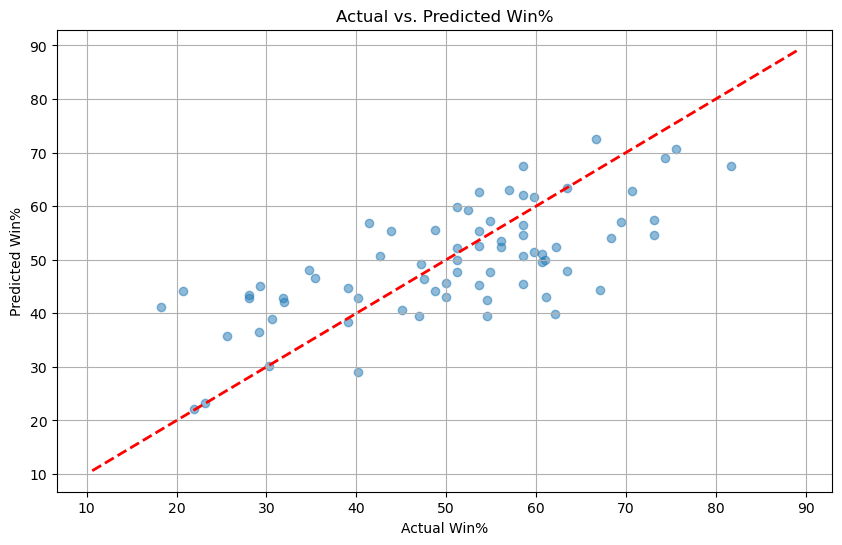

In [26]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonal line
plt.title('Actual vs. Predicted Win%')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.grid(True)
plt.show()
